In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# generate a dataset

class MyDataset(Dataset):
    def __init__(self, n_grads, H):
        super().__init__()
        self.grads = np.random.uniform(-1, 1, size=n_grads)
        self.x = torch.arange(0, 1, 0.01)
        self.H = H # horizon [steps]
        self.interval = H//2 # [steps]

        self.len = n_grads

    def __getitem__(self, idx):
        """
        1. sample `grads`
        2. generate linear data (seq_len*input_size)
        Remarks: (batch_size*seq_len*input_size) is formed by DataLoader.
        """
        H = self.H

        # 1.
        grad = self.grads[idx]

        # 2.
        y = grad * self.x

        subys = torch.tensor([])  # (seq_len*input_size(H))
        i = 0
        while len(y[i:i+H]) == H:
            suby = y[i:i+H].view(1, -1)
            subys = torch.cat((subys, suby), 0)
            i += self.interval

        return subys, grad

    def __len__(self):
        return self.len

In [2]:
class LSTM(nn.Module):
    def __init__(self, in_size):
        super().__init__()
        self.in_size = in_size
        self.h_size = 32
        self.n_layers = 2

        # define the LSTM layer
        self.lstm = nn.LSTM(self.in_size, self.h_size, self.n_layers, 
                            batch_first=True)
        self.h_n = None  # hidden state
        self.c_n = None  # cell state

        # define the output layer
        self.linear = nn.Linear(self.h_size, 1)  # predicts `linear-grad`

    def init_states(self, batch_size):
        """initialize the hidden and cell states"""
        self.h_n = torch.zeros(self.n_layers, batch_size, self.h_size)
        self.c_n = torch.zeros(self.n_layers, batch_size, self.h_size)

    def forward(self, x):
        """
        x: (batch, seq_len, input_size)

        out: (batch, seq_len, hidden_size)
        h_n, c_n: (num_layers * num_directions, batch, hidden_size)
        """
        states = (self.h_n, self.c_n)
        out, (self.h_n, self.c_n) = self.lstm(x, states)

        # get the last one of the (sequential) output from the LSTM
        out = out[:, -1, :]  # (batch, hidden_size)
        out = self.linear(out)  # (batch, 1)

        return out

In [3]:
# DataLoader
train_dataset = MyDataset(n_grads=30, H=10)
train_data_loader = DataLoader(train_dataset, batch_size=8)

val_dataset = MyDataset(n_grads=10, H=10)
val_data_loader = DataLoader(val_dataset, batch_size=8)


# Model
model = LSTM(in_size=train_dataset.H)


# Compile
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

In [4]:
# Train
n_epochs = 100

for epoch in range(1, n_epochs+1):

    # train
    i, train_loss, val_loss = 0, 0., 0.
    for x, y in train_data_loader:
        optimizer.zero_grad()

        model.init_states(batch_size=x.shape[0])
        out = model(x)
        loss = criterion(out, y.float().view(-1, 1))
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        i += 1
    train_loss /= i

    # validate
    with torch.no_grad():
        i = 0
        for x, y in val_data_loader:
            model.init_states(batch_size=x.shape[0])
            out = model(x)
            loss = criterion(out, y.float().view(-1, 1))
            val_loss += loss.item()
            i += 1
        val_loss /= i

    print('epoch: {} | train_loss: {:0.5f} | val_loss: {:0.5f}'.format(epoch, train_loss, val_loss))

epoch: 1 | train_loss: 0.39635 | val_loss: 0.44035
epoch: 2 | train_loss: 0.35664 | val_loss: 0.40485
epoch: 3 | train_loss: 0.32004 | val_loss: 0.36949
epoch: 4 | train_loss: 0.28282 | val_loss: 0.33024
epoch: 5 | train_loss: 0.24198 | val_loss: 0.28340
epoch: 6 | train_loss: 0.19625 | val_loss: 0.22813
epoch: 7 | train_loss: 0.14959 | val_loss: 0.17093
epoch: 8 | train_loss: 0.11338 | val_loss: 0.12470
epoch: 9 | train_loss: 0.09240 | val_loss: 0.09021
epoch: 10 | train_loss: 0.06962 | val_loss: 0.05967
epoch: 11 | train_loss: 0.04540 | val_loss: 0.03935
epoch: 12 | train_loss: 0.03159 | val_loss: 0.02717
epoch: 13 | train_loss: 0.02373 | val_loss: 0.01700
epoch: 14 | train_loss: 0.01802 | val_loss: 0.01161
epoch: 15 | train_loss: 0.01618 | val_loss: 0.01098
epoch: 16 | train_loss: 0.01531 | val_loss: 0.01039
epoch: 17 | train_loss: 0.01314 | val_loss: 0.00950
epoch: 18 | train_loss: 0.01067 | val_loss: 0.00817
epoch: 19 | train_loss: 0.00821 | val_loss: 0.00627
epoch: 20 | train_los

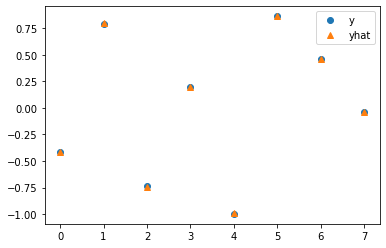

In [6]:
# Test
with torch.no_grad():
    for x, y in val_data_loader:
        model.init_states(batch_size=x.shape[0])
        out = model(x)
        break
        #loss = criterion(out, y.float().view(-1, 1))
        
# Plot
plt.plot(y.float(), 'o', label='y')
plt.plot(out.view(-1), '^', label='yhat')
plt.legend()